## 第7章: 単語ベクトル
単語の意味を実ベクトルで表現する単語ベクトル（単語埋め込み）に関して，以下の処理を行うプログラムを作成せよ．

### 60.単語ベクトルの読み込みと表示
Google Newsデータセット（約1,000億単語）での学習済み単語ベクトル（300万単語・フレーズ，300次元）をダウンロードし，”United States”の単語ベクトルを表示せよ．ただし，”United States”は内部的には”United_States”と表現されていることに注意せよ．

In [4]:
from gensim.models import KeyedVectors

path = 'data/GoogleNews-vectors-negative300.bin'
# The vectors can also be instantiated from an existing file on disk in the original Google’s word2vec C format as a KeyedVectors instance
word_vectors = KeyedVectors.load_word2vec_format(path, binary=True)  # C bin format
vector = word_vectors['United_States']
print(vector)

[-3.61328125e-02 -4.83398438e-02  2.35351562e-01  1.74804688e-01
 -1.46484375e-01 -7.42187500e-02 -1.01562500e-01 -7.71484375e-02
  1.09375000e-01 -5.71289062e-02 -1.48437500e-01 -6.00585938e-02
  1.74804688e-01 -7.71484375e-02  2.58789062e-02 -7.66601562e-02
 -3.80859375e-02  1.35742188e-01  3.75976562e-02 -4.19921875e-02
 -3.56445312e-02  5.34667969e-02  3.68118286e-04 -1.66992188e-01
 -1.17187500e-01  1.41601562e-01 -1.69921875e-01 -6.49414062e-02
 -1.66992188e-01  1.00585938e-01  1.15722656e-01 -2.18750000e-01
 -9.86328125e-02 -2.56347656e-02  1.23046875e-01 -3.54003906e-02
 -1.58203125e-01 -1.60156250e-01  2.94189453e-02  8.15429688e-02
  6.88476562e-02  1.87500000e-01  6.49414062e-02  1.15234375e-01
 -2.27050781e-02  3.32031250e-01 -3.27148438e-02  1.77734375e-01
 -2.08007812e-01  4.54101562e-02 -1.23901367e-02  1.19628906e-01
  7.44628906e-03 -9.03320312e-03  1.14257812e-01  1.69921875e-01
 -2.38281250e-01 -2.79541016e-02 -1.21093750e-01  2.47802734e-02
  7.71484375e-02 -2.81982

### 61.単語の類似度
“United States”と”U.S.”のコサイン類似度を計算せよ．

In [14]:
cosine_similarity = word_vectors.n_similarity(['United_States'], ['U.S.'])
print(cosine_similarity)

0.73107743


### 62.類似度の高い単語10件
“United States”とコサイン類似度が高い10語と，その類似度を出力せよ．

In [19]:
from pprint import pprint
most_similar_10_word = word_vectors.most_similar(positive=['United_States'], topn=10)
pprint(most_similar_10_word)

[('Unites_States', 0.7877248525619507),
 ('Untied_States', 0.7541370391845703),
 ('United_Sates', 0.74007248878479),
 ('U.S.', 0.7310774326324463),
 ('theUnited_States', 0.6404393911361694),
 ('America', 0.6178410053253174),
 ('UnitedStates', 0.6167312264442444),
 ('Europe', 0.6132988929748535),
 ('countries', 0.6044804453849792),
 ('Canada', 0.6019070148468018)]


### 63.加法構成性によるアナロジー
“Spain”の単語ベクトルから”Madrid”のベクトルを引き，”Athens”のベクトルを足したベクトルを計算し，そのベクトルと類似度の高い10語とその類似度を出力せよ．

In [16]:
from pprint import pprint

spain = word_vectors['Spain']
madrid = word_vectors['Madrid']
athens = word_vectors['Athens']

new_vec = spain - madrid + athens

most_similar_10_word = word_vectors.similar_by_vector(new_vec, topn=10)
pprint(most_similar_10_word)

[('Athens', 0.7528455853462219),
 ('Greece', 0.6685472726821899),
 ('Aristeidis_Grigoriadis', 0.5495778322219849),
 ('Ioannis_Drymonakos', 0.5361456871032715),
 ('Greeks', 0.5351786613464355),
 ('Ioannis_Christou', 0.5330226421356201),
 ('Hrysopiyi_Devetzi', 0.5088489055633545),
 ('Iraklion', 0.5059264898300171),
 ('Greek', 0.5040615797042847),
 ('Athens_Greece', 0.5034109354019165)]


### 64.アナロジーデータでの実験
単語アナロジーの評価データをダウンロードし，vec(2列目の単語) - vec(1列目の単語) + vec(3列目の単語)を計算し，そのベクトルと類似度が最も高い単語と，その類似度を求めよ．求めた単語と類似度は，各事例の末尾に追記せよ．

#### カテゴリーの種類
意味カテゴリ  
: capital-common-countries  
: capital-world  
: currency  
: city-in-state  
: family  
文法カテゴリ  
: gram1-adjective-to-adverb  
: gram2-opposite  
: gram3-comparative  
: gram4-superlative  
: gram5-present-participle  
: gram6-nationality-adjective  
: gram7-past-tense  
: gram8-plural  
: gram9-plural-verbs  

In [28]:
!wc -l data/questions-words.txt

   19558 data/questions-words.txt


In [70]:
from itertools import islice
import pandas as pd
from tqdm import tqdm

with open('data/questions-words.txt','r') as f:
    dic_sem, dic_syn = [], []
    for l in tqdm(f):
        
        if l.startswith(':'):
            category = l.strip(':\n ')
            
        else:
            words = l.strip().split(' ')
            similar_word = word_vectors.most_similar(positive=[words[1], words[2]], negative=[words[0]], topn=1)
            
            if category.startswith('gram'):
                dic_syn.append({'category': category, 'w1': words[0], 'w2': words[1], 'w3': words[2],
                                'gold': words[3], 'pred': similar_word[0][0], 'similarity': similar_word[0][1]})
            else:
                dic_sem.append({'category': category, 'w1': words[0], 'w2': words[1], 'w3': words[2],
                                'gold': words[3], 'pred': similar_word[0][0], 'similarity': similar_word[0][1]})
    
    df_sem, df_syn = pd.DataFrame(dic_sem), pd.DataFrame(dic_syn)
    df_syn.to_csv('data/Q64_syn.csv')
    df_sem.to_csv('data/Q64_sem.csv')

19558it [8:57:14,  1.65s/it]  


In [76]:
print(df_syn[:5])

                    category       w1         w2         w3         gold  \
0  gram1-adjective-to-adverb  amazing  amazingly   apparent   apparently   
1  gram1-adjective-to-adverb  amazing  amazingly       calm       calmly   
2  gram1-adjective-to-adverb  amazing  amazingly   cheerful   cheerfully   
3  gram1-adjective-to-adverb  amazing  amazingly   complete   completely   
4  gram1-adjective-to-adverb  amazing  amazingly  efficient  efficiently   

                    pred  similarity  
0             apparently    0.481730  
1                   Calm    0.557637  
2          irrepressibly    0.593142  
3             completing    0.463903  
4  market_hypothesis_EMH    0.545214  


In [78]:
print(df_sem[:5])

                   category      w1      w2       w3         gold  \
0  capital-common-countries  Athens  Greece  Baghdad         Iraq   
1  capital-common-countries  Athens  Greece  Bangkok     Thailand   
2  capital-common-countries  Athens  Greece  Beijing        China   
3  capital-common-countries  Athens  Greece   Berlin      Germany   
4  capital-common-countries  Athens  Greece     Bern  Switzerland   

          pred  similarity  
0        Iraqi    0.635187  
1     Thailand    0.713767  
2        China    0.723578  
3      Germany    0.673462  
4  Switzerland    0.491975  


### 65.アナロジータスクでの正解率
64の実行結果を用い，意味的アナロジー（semantic analogy）と文法的アナロジー（syntactic analogy）の正解率を測定せよ．

In [114]:
from pandas import read_csv
from itertools import islice

def get_accuracy(file):
    df = read_csv(file)
    correct_count = 0
    all_count = 0
    for i, data in df.iterrows():
        all_count += 1
        if data['pred'] == data['gold']:
            correct_count += 1
    return correct_count / all_count

In [115]:
get_accuracy('data/Q64_sem.csv')

0.7308602999210734

In [116]:
get_accuracy('data/Q64_syn.csv')

0.7400468384074942

### 66.WordSimilarity-353での評価
The WordSimilarity-353 Test Collectionの評価データをダウンロードし，単語ベクトルにより計算される類似度のランキングと，人間の類似度判定のランキングの間のスピアマン相関係数を計算せよ．

In [119]:
! unzip data/wordsim353.zip  -d data

Archive:  data/wordsim353.zip
  inflating: data/combined.csv       
  inflating: data/set1.csv           
  inflating: data/set2.csv           
  inflating: data/combined.tab       
  inflating: data/set1.tab           
  inflating: data/set2.tab           
  inflating: data/instructions.txt   


In [244]:
from csv import reader
from itertools import islice
from scipy.stats import spearmanr

with open('data/combined.csv','r') as csvfile: 
    df = read_csv(csvfile)
    df['similarity'] = 0
    
    for i, data in df.iterrows():
        similarity = word_vectors.similarity(data['Word 1'], data['Word 2'])
        df.iloc[i, 3] = similarity
    
    ranking = df.rank(ascending=False)    
    corr, p = spearmanr(ranking['Human (mean)'], ranking['similarity'])
    
    print(f'スピアマン相関係数： {corr}')
    print(f'p値： {p}')

スピアマン相関係数： 0.7000166486272194
p値： 2.86866666051422e-53


In [241]:
print(word_vectors.similarity('love','sex'))

0.2639377


In [142]:
print(word_vectors.wv.evaluate_word_pairs('data/combined.tab')[1])

/Users/seiya.k/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


SpearmanrResult(correlation=0.6589215888009288, pvalue=2.5346056459149263e-45)


### 67.k-meansクラスタリング
国名に関する単語ベクトルを抽出し，k-meansクラスタリングをクラスタ数k=5として実行せよ．

In [2]:
from pandas import read_csv

with open('data/Q64_sem.csv','r') as csv:
    df = read_csv(csv)
    new_df1 = df.query('category == "capital-world"')
    new_df2 = df.query('category == "capital-common-countries"')
    countries = set(new_df1['w2']) | set(new_df1['gold']) | set(new_df2['w2']) | set(new_df2['gold'])
    print(countries)

{'Greece', 'Croatia', 'Fiji', 'Nigeria', 'Turkmenistan', 'Greenland', 'Laos', 'Dominica', 'Italy', 'Malawi', 'Poland', 'Egypt', 'Denmark', 'Finland', 'Peru', 'Ghana', 'Syria', 'France', 'Tuvalu', 'Albania', 'Uganda', 'England', 'Portugal', 'Kyrgyzstan', 'Mali', 'Tajikistan', 'China', 'Jamaica', 'Botswana', 'Kazakhstan', 'Sweden', 'Spain', 'Kenya', 'Austria', 'Somalia', 'Belarus', 'Nicaragua', 'Bahrain', 'Rwanda', 'Mauritania', 'Ukraine', 'Azerbaijan', 'Germany', 'Suriname', 'Taiwan', 'Pakistan', 'Lithuania', 'Ireland', 'Mozambique', 'Afghanistan', 'Belgium', 'Angola', 'Romania', 'Bulgaria', 'Nepal', 'Turkey', 'Japan', 'Latvia', 'Liberia', 'Morocco', 'Cyprus', 'Bangladesh', 'Moldova', 'Qatar', 'Vietnam', 'Sudan', 'Canada', 'Tunisia', 'Uruguay', 'Slovenia', 'Uzbekistan', 'Libya', 'Bahamas', 'Lebanon', 'Philippines', 'Guinea', 'Georgia', 'Niger', 'Madagascar', 'Honduras', 'Gabon', 'Iran', 'Gambia', 'Venezuela', 'Chile', 'Australia', 'Hungary', 'Serbia', 'Russia', 'Bhutan', 'Jordan', 'Mont

In [323]:
from sklearn.cluster import KMeans

country_vecs = [word_vectors[c] for c in countries]
cluster = KMeans(n_clusters=5)
result = cluster.fit(country_vecs)

In [327]:
from pprint import pprint

d = {i: [] for i in range(5)}
for c, label in zip(countries, result.labels_):
    d[label].append(c)
pprint(d)

{0: ['Thailand',
     'Laos',
     'Vietnam',
     'Bhutan',
     'Taiwan',
     'Bangladesh',
     'Indonesia',
     'Philippines',
     'Nepal',
     'Japan',
     'China'],
 1: ['Syria',
     'Germany',
     'Austria',
     'Turkey',
     'England',
     'Algeria',
     'Lebanon',
     'Bahrain',
     'Afghanistan',
     'Greece',
     'Pakistan',
     'Jordan',
     'Egypt',
     'Qatar',
     'Malta',
     'Belgium',
     'Greenland',
     'Spain',
     'Oman',
     'Morocco',
     'Australia',
     'Italy',
     'Portugal',
     'Denmark',
     'Iran',
     'Sweden',
     'Iraq',
     'Ireland',
     'France',
     'Canada',
     'Norway',
     'Libya',
     'Tunisia',
     'Liechtenstein',
     'Switzerland'],
 2: ['Kenya',
     'Gabon',
     'Somalia',
     'Rwanda',
     'Burundi',
     'Ghana',
     'Zimbabwe',
     'Namibia',
     'Senegal',
     'Gambia',
     'Madagascar',
     'Uganda',
     'Eritrea',
     'Malawi',
     'Mauritania',
     'Mozambique',
     'Zambia',
  

### 68.Ward法によるクラスタリング
国名に関する単語ベクトルに対し，Ward法による階層型クラスタリングを実行せよ．さらに，クラスタリング結果をデンドログラムとして可視化せよ．

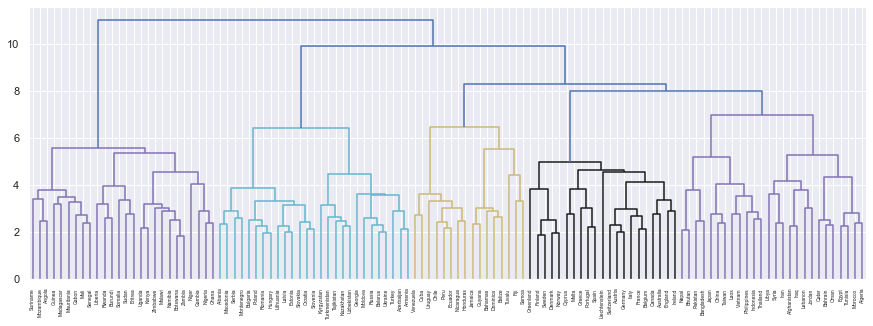

In [10]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from scipy.cluster import hierarchy

country_vecs = [word_vectors[c] for c in countries]
result = linkage(country_vecs, method='ward')

hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
# hierarchy.set_link_color_palette(None)
fig = plt.figure(figsize=(15, 5))
font = plt.rcParams['font.size'] = 22

dendro = dendrogram(result, labels=list(countries))

### 69.t-SNEによる可視化
ベクトル空間上の国名に関する単語ベクトルをt-SNEで可視化せよ

In [11]:
from sklearn.manifold import TSNE

embeds = TSNE().fit_transform(country_vecs)

print(len(country_vecs))
print(embeds.shape)

116
(116, 2)


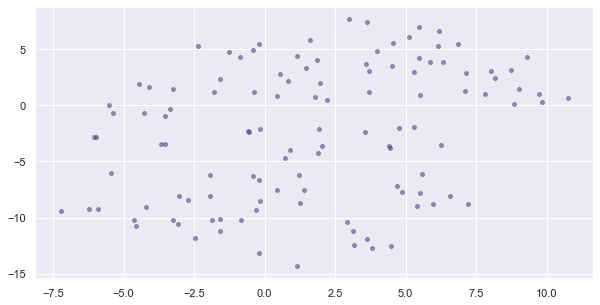

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_palette('viridis') 
fig = plt.figure(figsize=(10, 5))

plt.scatter(embeds[:, 0], embeds[:, 1], s=15, alpha=0.5, linewidths=1.0)
plt.show()